In [ ]:
!pip install captum

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import statistics
import random

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models
from matplotlib.pyplot import imshow
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import torch.optim as optim

In [3]:
"""Creating datasets and dataloaders"""
transform = transforms.ToTensor()

#CIFAR10: 32x32 img
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = train_dataset.classes
print('Number of classes:', len(classes))


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of classes: 10


In [5]:
"""Defining the CNN:"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()                                                               # CIFAR10: 32x32 img
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), padding=(2,2))  # 32 activation maps on 32x32 img
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)                                                            # 32 activation maps on 16x16 img
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=(5,5), padding=(2,2))  # 64 activation maps on 16x16 img
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)                                                            # 64 activation maps on 8x8 img
        self.flat = nn.Flatten()                                                                  # 64 * 8 *8 units
        self.fc1 = nn.Linear(64*8*8, 1024)                                                        # 1024 units
        self.relu3 = nn.ReLU()
        self.softmax = nn.Softmax()                                                               # 10 units

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.fc1(self.flat(x)))
        x = self.softmax(x)
        return x

net = Net()

"""Defining loss function and optimizer:"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), weight_decay=0.001)

In [ ]:
"""Visualizing a few examples:"""
def show_examples(n, train_dataset, classes):
    for i in range(n):
        index = torch.randint(0, len(train_dataset), size=(1,))  # select a random example
        image, label = train_dataset[index]
        print('label:', classes[label])
        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.show()

show_examples(2, train_dataset, classes)

In [13]:
"""Training:"""
use_gpu = True if torch.cuda.is_available() else False
print(f'Using cuda: {use_gpu}')
if use_gpu: net = net.cuda()

USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
  print("Using existing trained model")
  net.load_state_dict(torch.load('cifar_torchvision.pt'))
else:
  for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    losses = []
    for i, data in enumerate(train_dataloader, 0):
      # get the inputs
      inputs, labels = data
      if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize + loss
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

    print("Epoch", epoch + 1, ": Current training loss", statistics.mean(losses))

  print('Finished Training')
  torch.save(net.state_dict(), 'cifar_torchvision.pt')

Using cuda: False


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 : Current training loss 6.833341454620362
Epoch 2 : Current training loss 6.833897424507141
Finished Training


In [14]:
"""Validation:"""
with torch.no_grad():
    running_loss = 0.0
    correct, total = 0, 0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        if use_gpu:
          inputs = inputs.cuda()
          labels = labels.cuda()
        # forward + loss + prediction
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        # select the class with the largest value
        predicted = outputs.argmax(1)

        total += len(labels)
        correct += (predicted == labels).sum().item()

print('Validation loss:', running_loss / len(test_dataloader))
print('Accuracy on the validation set:', 100 * correct / total, '%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss: 6.833147908592224
Accuracy on the validation set: 10.0 %


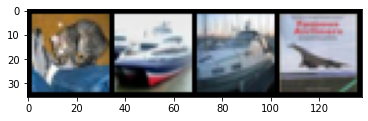

GroundTruth:    cat  ship  ship airplane
Predicted:   frog  frog  frog  frog


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
"""Perform a few predictions"""
def imgshow(img, transpose = True):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# print images + predictions
imgshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


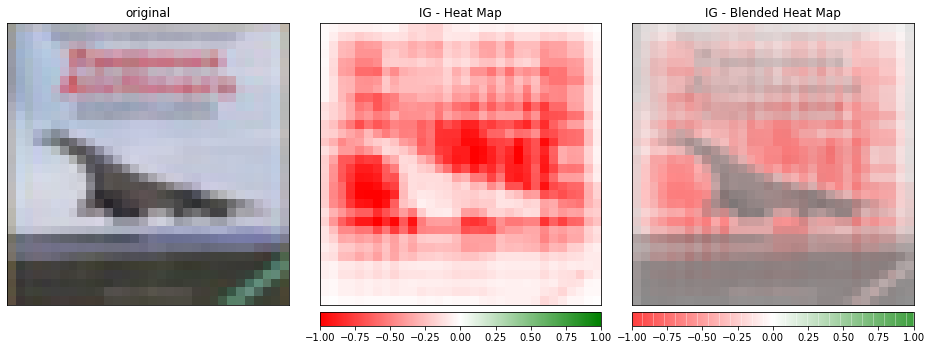

In [52]:
def saliencyMap(index):
  net.zero_grad()
  net.eval()

  images, labels = next(iter(test_dataloader))
  if torch.cuda.is_available():
    images = images.cuda()
    labels = labels.cuda()

  ig = IntegratedGradients(net)
  attributions_ig = ig.attribute(images[index].unsqueeze(0), target=labels[index])
  attributions_ig = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
  img = np.transpose(images[index].cpu().detach().numpy(), (1, 2, 0))

  viz.visualize_image_attr_multiple(attributions_ig, img, methods=["original_image", "heat_map", "blended_heat_map"], 
                                    signs=["","all","all"], show_colorbar=True, fig_size=(13,5), 
                                    titles=["original","IG - Heat Map","IG - Blended Heat Map"])

saliencyMap(3)

Stuff copy/paste from Captum Tutorial...


In [45]:
"""Choose a test image an index ind"""
ind = 3
input = images[ind].unsqueeze(0)
input.requires_grad = True

#set model to evaluation mode
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (relu3): ReLU()
  (softmax): Softmax(dim=None)
)

In [46]:
def attribute_image_features(algorithm, input, **kwargs):
  net.zero_grad()
  tensor_attributions = algorithm.attribute(input, target=labels[ind], **kwargs)
  
  return tensor_attributions

In [47]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [48]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([1.1370e-09], dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [49]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [50]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Original Image
Predicted: frog  Probability: 0.0026501270476728678


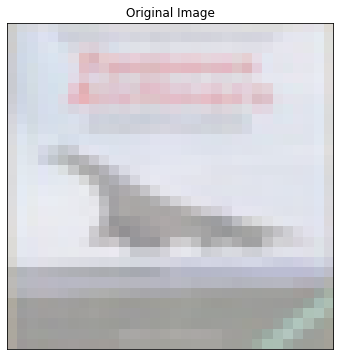

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


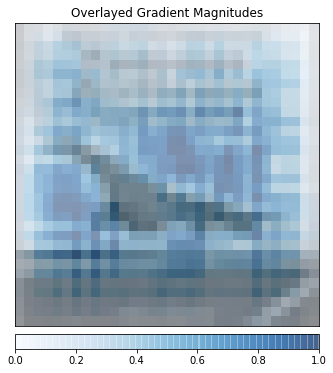

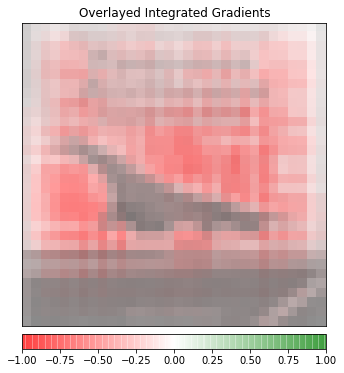

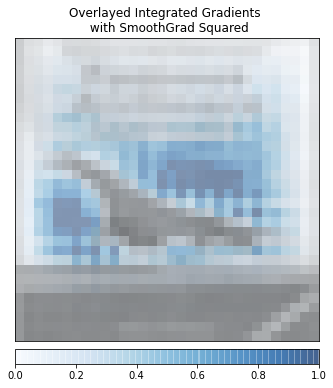

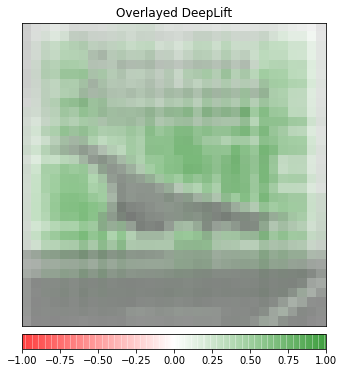

In [51]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")